# A/B Testing Process¶

### PACKAGES

In [2]:
# Base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
from scipy import stats
from scipy.stats import shapiro

# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../")

pd.set_option('display.max_columns', None)  # 모든 열을 출력할 수 있도록 설정
pd.options.display.float_format = '{:.4f}'.format

### DATA

- business problem: 난이도를 다르게 설정한 두 게임 버전의 retention 차이가 있는가
- data: cookie_cats.csv
    - retention은 특정 기간이 지난 후, 사용자가 얼마나 다시 돌아와 서비스를 이용하는지를 의미.
    - retention rate(유지율) = (N일 후 돌아온 사용자 수 ÷ N일 전에 서비스를 이용한 사용자 수) × 100
    - retention_1 : 1일 후에도 접속했는지 T/F
    - retention_7 : 7일 후에도 접속했는지 T/F
    - sum_gamerounds : 사용자가 첫 14일간 플레이한 게임 라운드 수 
    - version : 사용자가 플레이한 버전 (gate_30 : 통제그룹, 30레벨에 게이트가 위치한 케이스, gate_40 : 실험그룹, 40레벨에 게이트가 위치한 케이스)
      - gate에 대한 정의: 플레이 중 만나게 되는 "인-앱 구매 또는 적지 않은 시간을 기다리게 하는 장애물"

In [26]:
from utils import load_data

data = load_data("datasets/cookie_cats.csv", info=True)

# [INFO] Data Columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### SUMMARY STATS
- 결측치는 없다.
- gate_30에 혼자 49,854개의 라운드를 진행한 이상치가 있다.

In [7]:
from utils import check_missing_values, check_key_column

_ = check_missing_values(data, info=True)
_ = check_key_column(data, "userid", info=True)

# [INFO] There is no missing value in the dataset.
# [INFO] The column is the key column.


In [10]:
# summary stats
display(data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T)
display(data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"]))
display(data.groupby("version")[['retention_1', 'retention_7']].mean())

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


,retention_1,retention_7
version,,
gate_30,0.4482,0.1902
gate_40,0.4423,0.1820


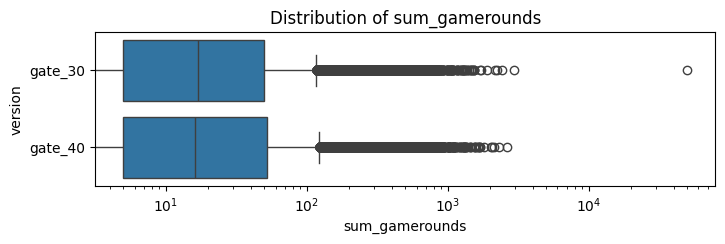

In [20]:
from utils import draw_distribution
    
draw_distribution(data, "sum_gamerounds", hue='version', shape='box', log_scale=True, transpose=True)

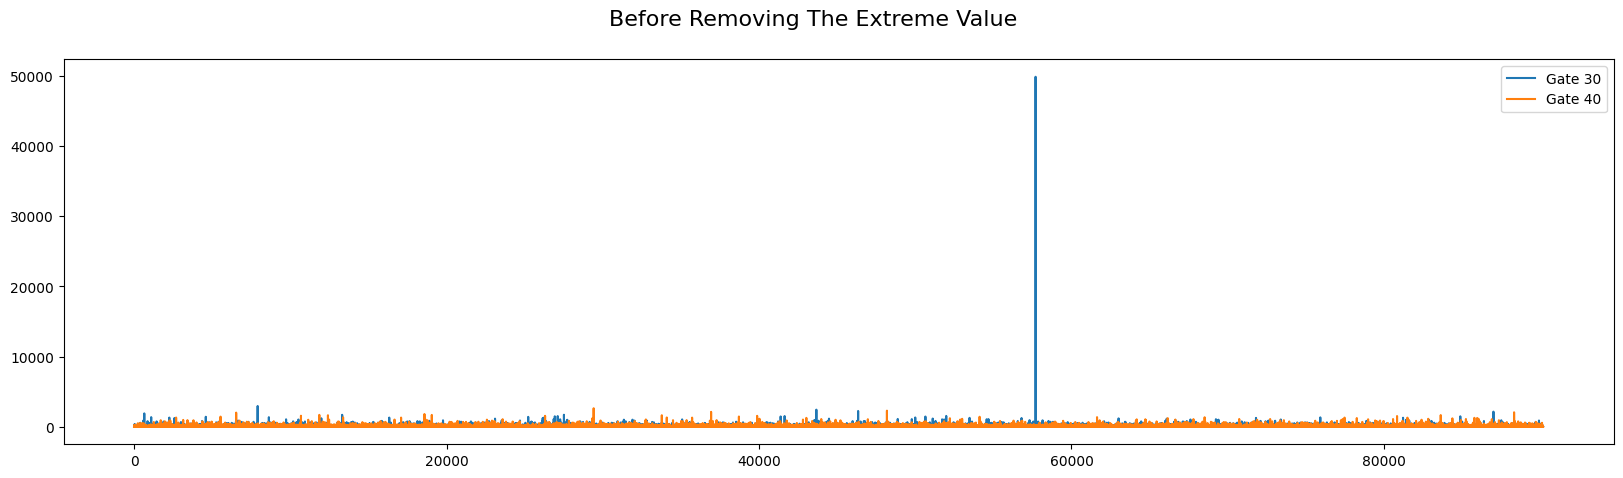

In [17]:
data[data.version == 'gate_30'].sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))
data[data.version == 'gate_40'].sum_gamerounds.plot(legend=True, label="Gate 40", figsize=(20, 5))
plt.suptitle("Before Removing The Extreme Value", fontsize=16)
plt.show()

### OUTLIERS
- 이상치를 제거해주었다.

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


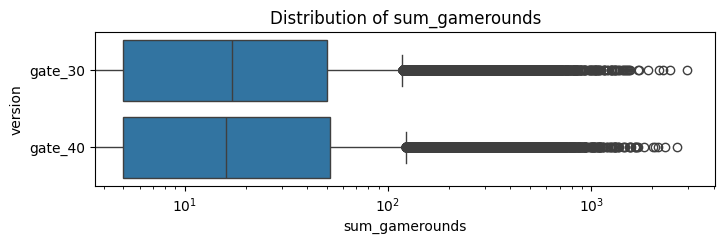

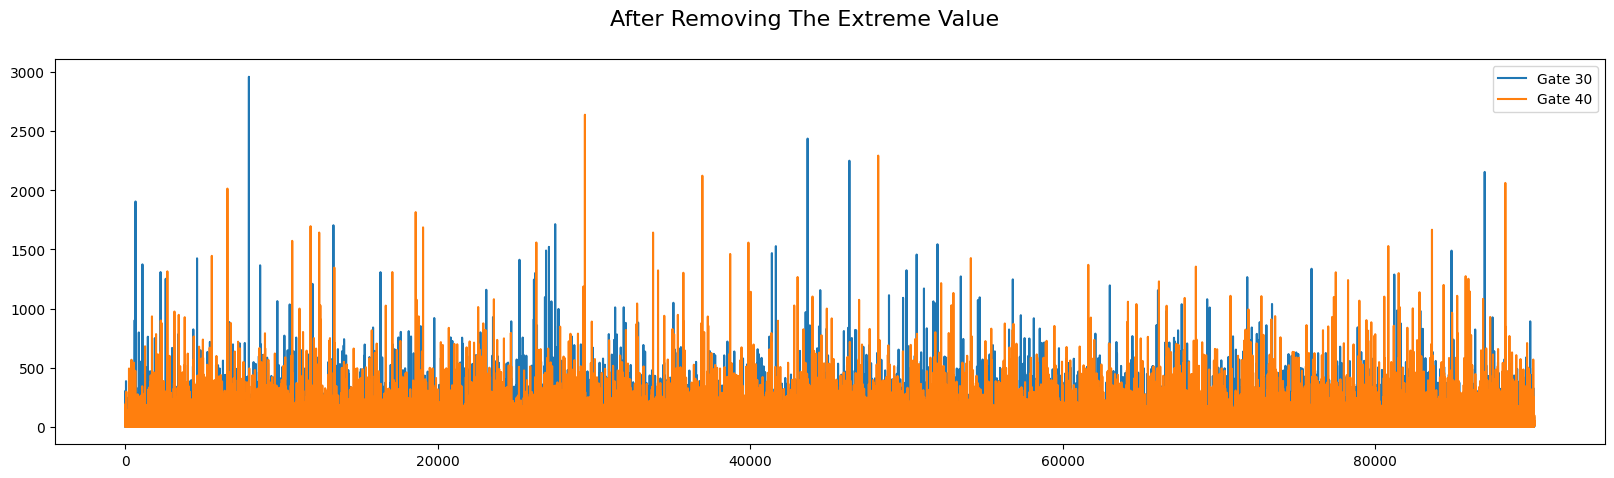

In [23]:
# remove outliers
_data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
display(_data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"]))
draw_distribution(_data, "sum_gamerounds", hue='version', shape='box', log_scale=True, transpose=True)
_data[_data.version=='gate_30'].sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))
_data[_data.version=='gate_40'].sum_gamerounds.plot(legend=True, label="Gate 40", figsize=(20, 5))
plt.suptitle("After Removing The Extreme Value", fontsize=16)
plt.show()

### SOME INSIGHTS 1.
- 게임을 설치했으나 한 번도 플레이하지 않은 사용자가 3,994명(4.43%)이나 된다. 다음의 이유를 떠올려볼 수 있다.
  - 그들은 게임을 플레이할 시간이 없었다. 아직 시작하지 않았다.
  - 동시에 여러 게임을 다운로드 했으나 다른 게임에 매료되었다.
  - 게임 내의 무엇(디자인/인터페이스/음악)이 그들의 마음에 들지 않아 바로 종료하였다.

In [92]:
data = _data.copy()
data.groupby("sum_gamerounds").userid.count().reset_index().head(5)
print(data.groupby("sum_gamerounds").userid.count()[0]/ data.groupby("sum_gamerounds").userid.count().sum())

0.04428527076772963


### SOME INSIGHT 2.
- 아예 플레이하지 않은 사용자를 제외하고도 약 10,000명(11.25%)의 유저가 3 라운드 이하를 플레이했다.
  - 초기에 이탈하는 사용자가 많다.
  - 그들의 기대와 플레이 경험이 맞지 않았다.
  - 게임이 지루하거나 너무 어려웠다.

10144 0.11247616090832484


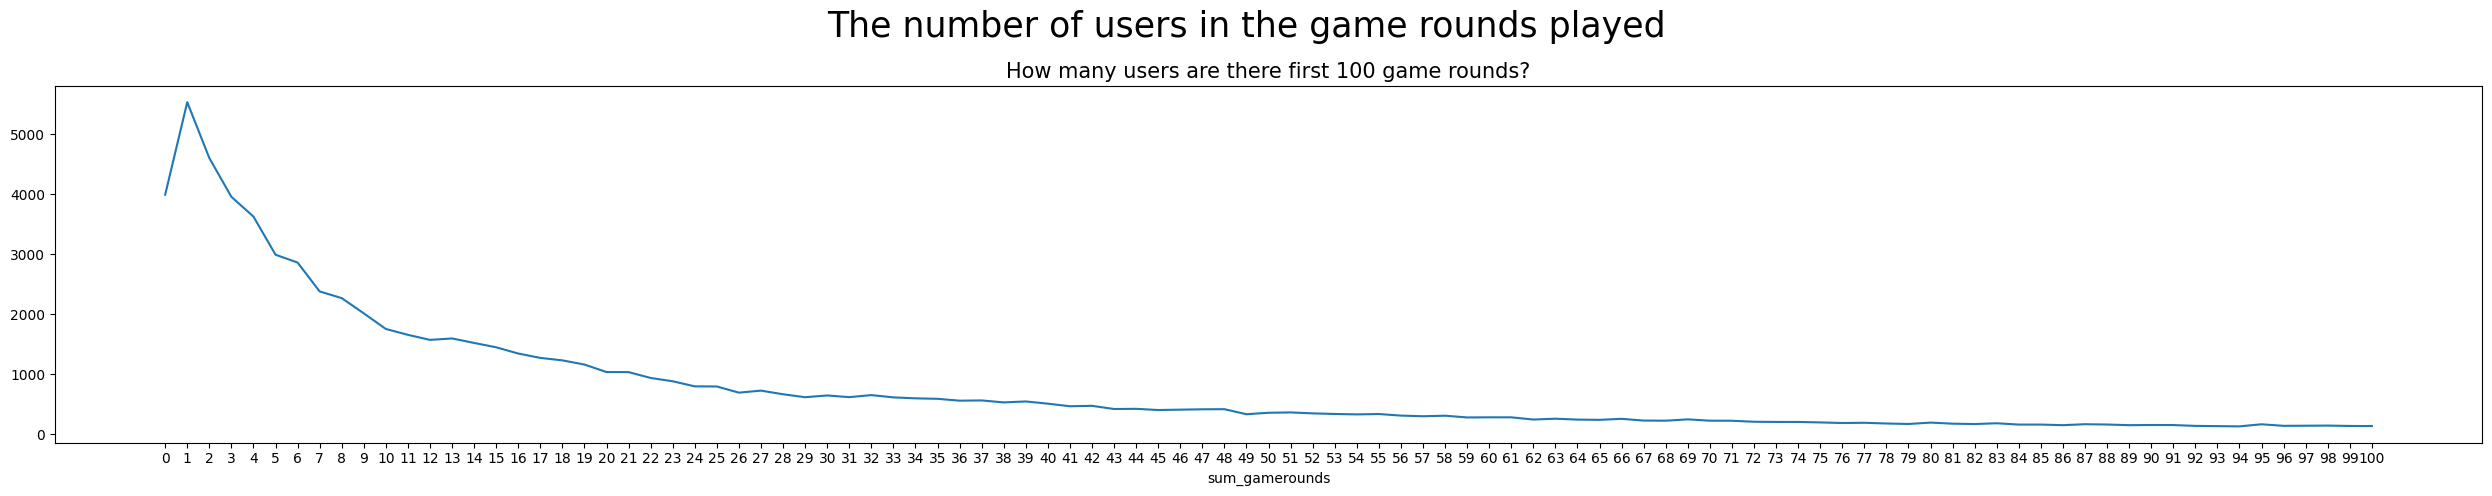

In [95]:
data = _data.copy()
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
data.groupby("sum_gamerounds").userid.count().head(101).plot(ax=ax)
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
ax.set_title("How many users are there first 100 game rounds?", fontsize = 15)
ax.set_xticks(range(0, 101, 1))
plt.tight_layout(pad=1)
print(
    tmp:=(data.groupby("sum_gamerounds").userid.count().head(3).sum() - data.groupby("sum_gamerounds").userid.count()[0]),
    tmp/data.groupby("sum_gamerounds").userid.count().sum(),
)

### A/B TEST
#### TODO
- [ ] 정규성 검정 : 데이터가 정규분포를 따르는지 검정 for ANOVA, t-test 등 정규성 가정을 요구하는 통계 기법
  - Shapiro-Wilk Test, Kolmogorov-Smirnov Test, Anderson-Darling Test
  - p-value ≤ 0.05: 정규성을 따르지 않는다.
- [ ] 동일성 검정 : 두 그룹 이상의 분산(또는 분포)이 동일한지 확인 for 분산이 동일해야 하는 통계 기법
  - 분산이 동일하면 독립 표본 t-test에서 equal variance 가정을 적용, 다르면 Welch’s t-test를 사용
  - p-value ≤ 0.05: 분산이 동일하지 않다.
- [ ] A/B Test
  - 정규성 검정을 만족하면 t-test를 사용할 수 있고, 그렇지 않으면 비모수 검정(예: Mann-Whitney U Test)을 사용.
  - 동일성 검정을 만족하면 t-test에서 equal variance 가정을 사용
- [ ] 해석
  - 앞의 결과와 정량적 지표를 바탕으로 해석을 진행 

#### RESULT
- TBD

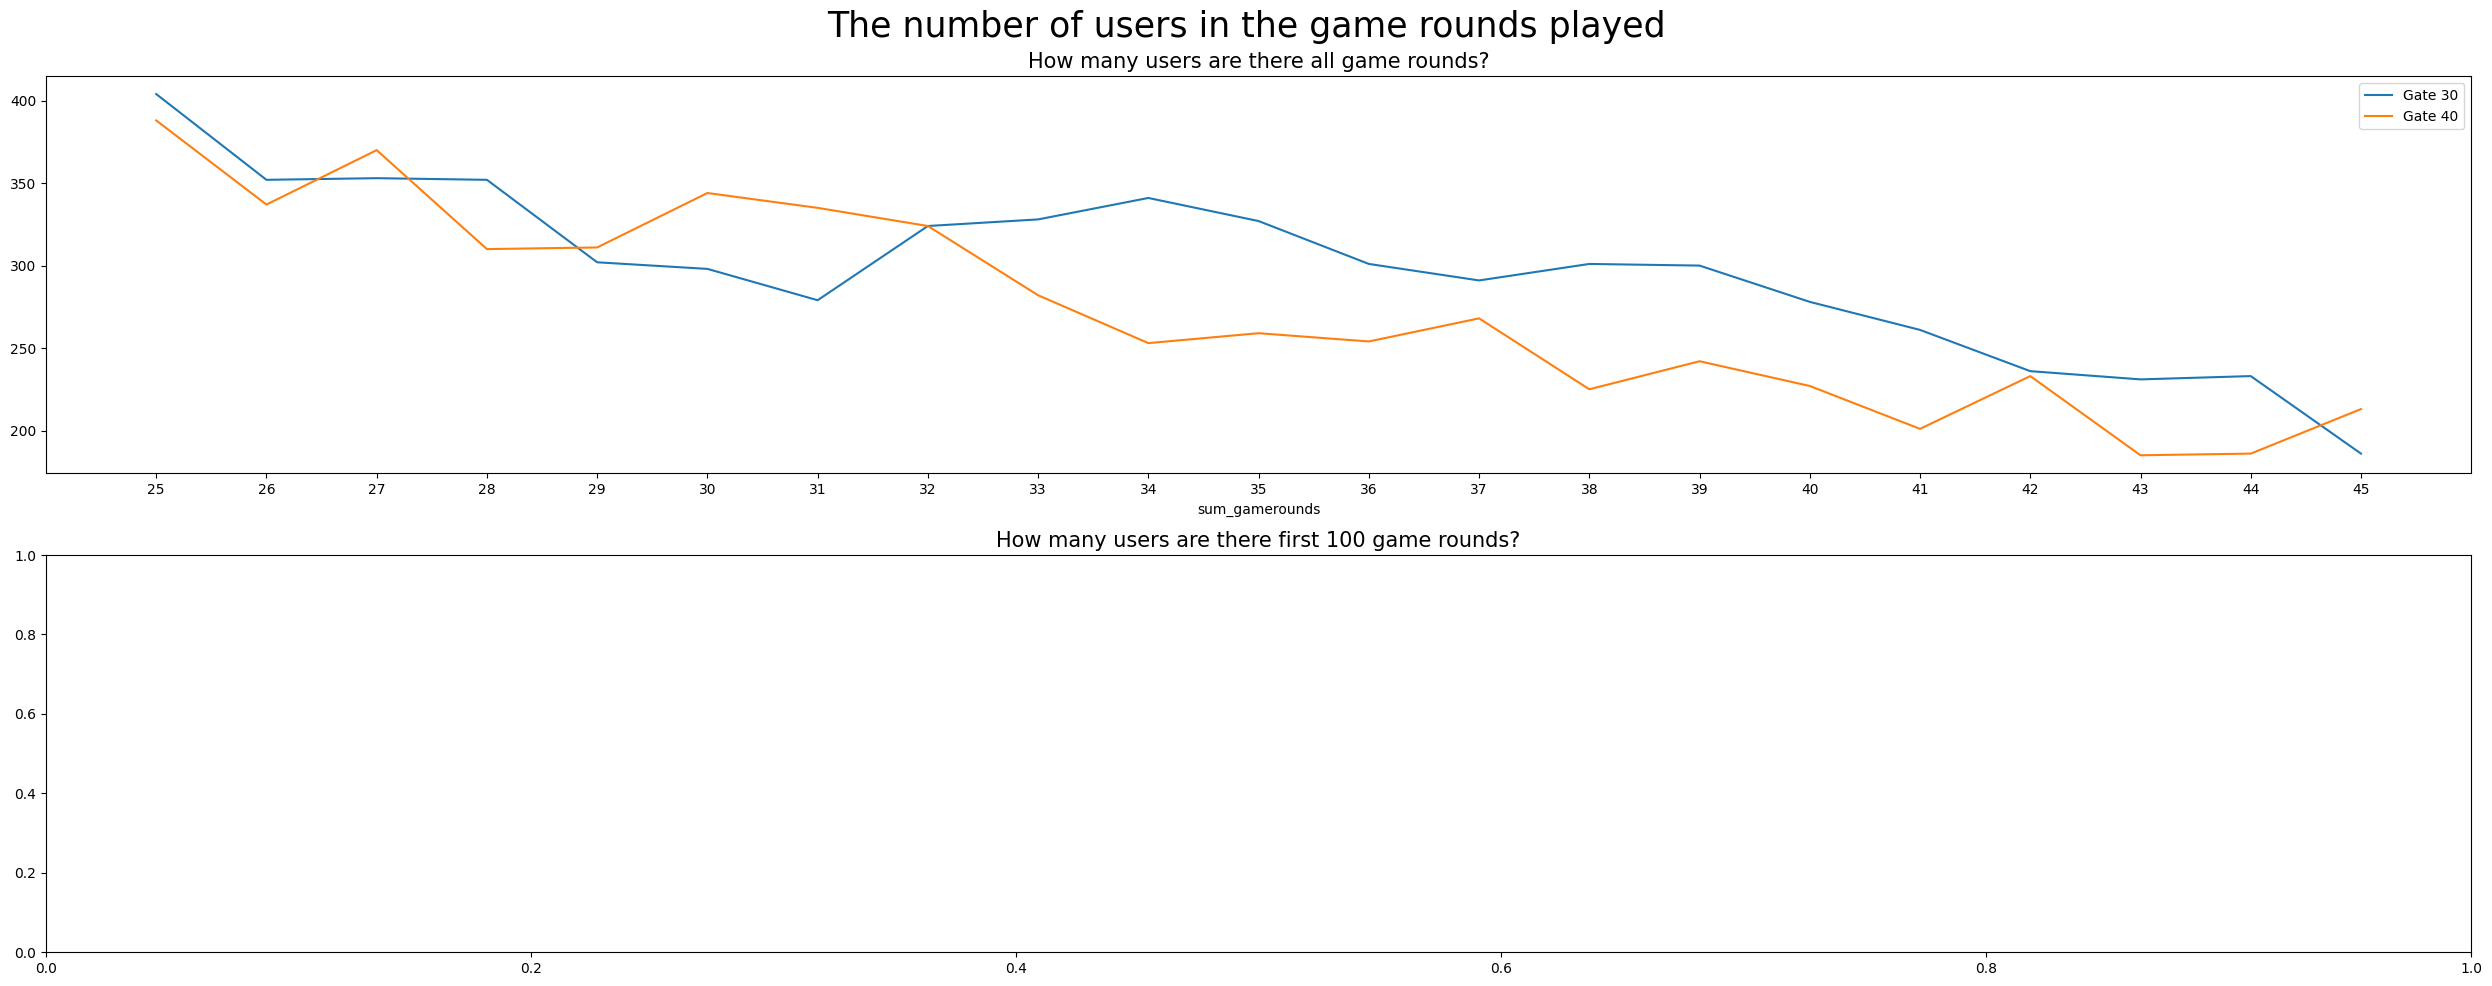

In [98]:
### EXTRA, 30 게이트의 영향을 분석할 수 있을까? (주관이 개입한 실험적 분석)
# 주어진 데이터로 같은 스테이지를 몇 번 반복했는가에 대해서는 알 수 없으나, 
# 일반적으로 초반 스테이지에서 스테이지를 반복하지 않는다고 가정했을 때 30<=sum_gamerounds<40 데이터로부터
# version 1과 2의 차이가 나타나지 않을까? -> retention_1, retention_7 에 대해 비교 분석
data = _data.copy()
fig, axes = plt.subplots(2, 1, figsize=(25, 10))
data[data.version=='gate_30'].groupby("sum_gamerounds").userid.count()[25:46].plot(ax=axes[0], legend=True, label="Gate 30")
data[data.version=='gate_40'].groupby("sum_gamerounds").userid.count()[25:46].plot(ax=axes[0], legend=True, label="Gate 40")
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 100 game rounds?", fontsize = 15)
axes[0].set_xticks(range(25, 46, 1))
plt.tight_layout(pad=1)

최상위 1%내에서도 진짜 상위 몇 명이 아니면 난이도가 높을 때 게임 플레이 횟수가 많다. 그러나, 이상치로 분류될만큼 많이 한 케이스는 더 낮은 난이도에서 발생했다.

retention ratio에 초점을 맞춰 보면 일반적인 유저 집단에선 낮은 난이도에서 높은 점수가 나오지만, 상위 1% 집단에선 그 관계가 역전된다.

=> 목표로 하는 대상이 누구인가(e.g. 돈을 많이 쓰는 대상, 상위 1%, 대중성)를 결정하는 것이 중요하게 작용할 것

### 4. Apply hypothesis testing and check assumptions

In [ ]:
# A/B Testing Process¶
# 1. Understanding business problem & data
# 2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
# 3. Look summary stats and plots
# --todo-> 4. Apply hypothesis testing and check assumptions
#   - Check Normality & Homogeneity
#   - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
# 5. Evaluate the results
# 6. Make inferences
# 7. Recommend business decision to your customer/director/ceo etc.